HR аналитики
Таблица employees по сотрудникам
id
name
department
dt дата первого дня
manager_id
salary

Найти топ-3 зп по департаменту

SELECT *
FROM (
SELECT id,
        department,
        salary,
        DENSE_RANK() OVER (PARTITION BY department ORDER BY salary DESC) as salary_rn
FROM employees
)
WHERE salary_rn <= 3

Структура = дерево
Второй снизу
Выдача - manager_id1, 2, сотрудник

SELECT
      e1.manager_id as manager_2,
      e1.id as manager_1,
      e0.id as employee
FROM employees e0
LEFT JOIN employees e1 ON e0.manager_id = e1.id
WHERE e0.id NOT IN (
  SELECT manager_id
  FROM employees
)

Задача - есть два датасета:
1. Данные по добычам кристаллов на каждой смене с полями - id сотрудника, дата, количество добытых кристаллов
2. Данные по сотрудникам - id, дата трудоустройства, зарплата

Нужно:
1. Сгенерировать синтетические данные
2. На этих данных оценить, насколько хорошо работает предприятие
3. Разделить сотрудников на когорты, оценить какие когорты работают хорошо, а какие плохо

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

### Генерирую синтетические данные

In [2]:
### Данные по сотрудникам
n = 100 # Количество сотрудников

list_ids = [] # Список id сотрудников
for i in range(1, n+1):
  list_ids.append(i)

list_salaries = np.random.randint(50, 100, size=n, dtype=int)*1000 # Случайно определяем зарплату


start = pd.to_datetime('2022-01-01') # Минимальная дата трудоустройства сотрудника
end = pd.to_datetime('2024-12-31') # Максимальная дата трудоустройства. Не беру текущую, иначе в дальнейшей генерации может быть перекос в данных по самым свежим сотрудникам

list_start_dt = pd.to_datetime(np.random.randint(start.value, end.value, size=n)).normalize() # Случайно создаем дату трудоустройства сотрудника

dict_employee ={
    'id':list_ids,
    'dt_start':list_start_dt,
    'salary':list_salaries
}

df_employee = pd.DataFrame(dict_employee)
df_employee

,id,dt_start,salary
0,1,2023-02-03,83000
1,2,2023-05-28,82000
2,3,2023-01-18,93000
3,4,2023-09-27,82000
4,5,2022-08-16,56000
...,...,...,...
95,96,2024-06-15,66000
96,97,2023-06-22,86000
97,98,2023-12-07,55000
98,99,2024-05-07,57000


In [3]:
### Данные по сменам
m = 10000 # Количество смен
list_num = np.random.randint(20, 100, size=m, dtype=int) # Количество добытых кристаллов за смену

list_smena = []
for i in range(m):
  id = np.random.choice(list_ids, size=1, replace=True, p=None)[0] # Случайно с повторениями берем для каждой смены id сотрудника

  start = df_employee.loc[df_employee['id'] == id, 'dt_start'].min() # Надо так случайно сгенерировать дату смены, чтобы она была не раньше даты трудоустройства, так что получаю дату трудоустройства
  end = pd.Timestamp(datetime.today().date())
  dt = pd.to_datetime(np.random.randint(start.value, end.value, size=1)).normalize()[0]

  list_smena.append([id, dt, list_num[i]])


df_smena = pd.DataFrame(data=list_smena, columns=['id', 'dt', 'num'])
df_smena

,id,dt,num
0,83,2024-03-24,34
1,10,2025-07-17,64
2,19,2023-01-01,96
3,4,2024-11-13,54
4,22,2024-05-23,29
...,...,...,...
9995,47,2022-08-05,34
9996,31,2025-06-03,23
9997,82,2024-08-31,27
9998,62,2025-06-24,82


### Анализ ситуации хорошо или плохо
Оценим следующее:
1. В целом посмотрим средние значения на смену, сотрудника, а также общую добычу
2. Затраты на добычу. <b> Допущение - зарплата месячная и мы платим ее, даже если сотрудник не отработал ни одной смены. И за неполные месяца платим пропорционально прошедшему времени </b>
3. Поскольку для хорощо/плохо нужен бенчмарк для сравнения, единственное с чем можно сравнить это с самими собой в прошлом. Поэтому будем смотреть в динамике по месяцам
4. Если все не очень, то анализ по факторам

In [4]:
# Для расчета костов, поскольку сделал допущение о зп выше, нужен df для расчета костов помесячно

today = pd.Timestamp(datetime.today().date().replace(day=1)) # Получаем первый день текущего месяца
month_rows = [] # Сюда будем писать все новые строки на дозапись

for i, row in df_employee.iterrows(): # Создаю на каждый месяц жизни сотрудника по строке
  employee_id = row['id']
  dt_start = row['dt_start']
  salary = row['salary']
  start_month = row['dt_start'].replace(day=1)

  while start_month <= today:
      month_rows.append({
            'id': employee_id,
            'dt_start': dt_start,
            'salary': salary,
            'start_month': start_month
      })
      start_month += relativedelta(months=1)


df_cost_monthly = pd.DataFrame(month_rows)
df_cost_monthly['end_month'] = df_cost_monthly['start_month'] + pd.offsets.MonthEnd(0)

def real_salary(row): # Получаю реальную зп в этот месяц
  if row['start_month'] == row['dt_start'].replace(day=1):
    real_salary = row['salary']/row['end_month'].day*(row['end_month'].day-row['dt_start'].day) # Если это первый месяц работы сотрудника, то умножаем зп на прцент фактически отработанных дней
  elif row['start_month'] == today:
    real_salary = row['salary']/row['end_month'].day*date.today().day # Если это текущий месяц, то он може тбыть не закончен и зп неполная
  else:
    real_salary = row['salary']

  return real_salary

df_cost_monthly['real_salary'] = df_cost_monthly.apply(real_salary, axis=1)

df_cost_monthly

,id,dt_start,salary,start_month,end_month,real_salary
0,1,2023-02-03,83000,2023-02-01,2023-02-28,74107.142857
1,1,2023-02-03,83000,2023-03-01,2023-03-31,83000.000000
2,1,2023-02-03,83000,2023-04-01,2023-04-30,83000.000000
3,1,2023-02-03,83000,2023-05-01,2023-05-31,83000.000000
4,1,2023-02-03,83000,2023-06-01,2023-06-30,83000.000000
...,...,...,...,...,...,...
2465,100,2024-05-20,52000,2025-03-01,2025-03-31,52000.000000
2466,100,2024-05-20,52000,2025-04-01,2025-04-30,52000.000000
2467,100,2024-05-20,52000,2025-05-01,2025-05-31,52000.000000
2468,100,2024-05-20,52000,2025-06-01,2025-06-30,52000.000000


In [5]:
# По каждому сотруднику и месяцу получим число добытых кристаллов и число смен
df_smena['start_month'] = df_smena['dt'].apply(lambda x: x.replace(day=1))
df_smena_by_employee_month = df_smena.groupby(['id', 'start_month'], as_index=False).agg(
    total_num=('num', 'sum'),
    smena_num=('num', 'count')
)


In [6]:
# Теперь можно получить df по каждому сотруднику на каждый месяц его работы - сколько смен отработал, сколько кристаллов добыл, и далее с этим работать
df_total_by_employee_month = pd.merge(df_cost_monthly,
                                      df_smena_by_employee_month,
                                      how='left',
                                      on=['id', 'start_month']).fillna(0)
df_total_by_employee_month

,id,dt_start,salary,start_month,end_month,real_salary,total_num,smena_num
0,1,2023-02-03,83000,2023-02-01,2023-02-28,74107.142857,234.0,4.0
1,1,2023-02-03,83000,2023-03-01,2023-03-31,83000.000000,86.0,2.0
2,1,2023-02-03,83000,2023-04-01,2023-04-30,83000.000000,58.0,1.0
3,1,2023-02-03,83000,2023-05-01,2023-05-31,83000.000000,142.0,2.0
4,1,2023-02-03,83000,2023-06-01,2023-06-30,83000.000000,274.0,5.0
...,...,...,...,...,...,...,...,...
2465,100,2024-05-20,52000,2025-03-01,2025-03-31,52000.000000,320.0,5.0
2466,100,2024-05-20,52000,2025-04-01,2025-04-30,52000.000000,239.0,3.0
2467,100,2024-05-20,52000,2025-05-01,2025-05-31,52000.000000,600.0,8.0
2468,100,2024-05-20,52000,2025-06-01,2025-06-30,52000.000000,288.0,6.0


In [7]:
# Посчитаем тоталы
df_total = df_total_by_employee_month.copy()
df_total['type'] = 'total'
df_total = df_total.groupby('type').agg(
    all_cristall_num=('total_num', 'sum'),
    all_smena_num=('smena_num', 'sum'),
    number_of_employees=('id', 'nunique'),
    total_salary_paid=('salary', 'sum')
)

df_total['avg_cristall_per_smena'] = df_total['all_cristall_num']/df_total['all_smena_num']
df_total['avg_cristall_per_employee'] = df_total['all_cristall_num']/df_total['number_of_employees']
df_total['cost_per_cristall'] = df_total['total_salary_paid']/df_total['all_cristall_num']

df_total

,all_cristall_num,all_smena_num,number_of_employees,total_salary_paid,avg_cristall_per_smena,avg_cristall_per_employee,cost_per_cristall
type,,,,,,,
total,595583.0,10000.0,100,181898000,59.5583,5955.83,305.411672


In [14]:
# Просто тотал неинформативный, поэтому выводим по месяцам

df_total_by_month = df_total_by_employee_month.groupby('start_month', as_index=False).agg(
    all_cristall_num=('total_num', 'sum'),
    all_smena_num=('smena_num', 'sum'),
    number_of_employees=('id', 'nunique'),
    total_salary_paid=('salary', 'sum')
)

df_total_by_month['avg_cristall_per_smena'] = df_total_by_month['all_cristall_num']/df_total_by_month['all_smena_num']
df_total_by_month['avg_cristall_per_employee'] = df_total_by_month['all_cristall_num']/df_total_by_month['number_of_employees']
df_total_by_month['avg_smena_per_employee'] = df_total_by_month['all_smena_num']/df_total_by_month['number_of_employees']
df_total_by_month['cost_per_cristall'] = df_total_by_month['total_salary_paid']/df_total_by_month['all_cristall_num']
df_total_by_month['cost_per_employee'] = df_total_by_month['total_salary_paid']/df_total_by_month['number_of_employees']

df_total_by_month

,start_month,all_cristall_num,all_smena_num,number_of_employees,total_salary_paid,avg_cristall_per_smena,avg_cristall_per_employee,avg_smena_per_employee,cost_per_cristall,cost_per_employee
0,2022-01-01,0.0,0.0,1,81000,NaN,0.000000,0.000000,inf,81000.000000
1,2022-02-01,163.0,3.0,2,180000,54.333333,81.500000,1.500000,1104.294479,90000.000000
2,2022-03-01,350.0,6.0,4,321000,58.333333,87.500000,1.500000,917.142857,80250.000000
3,2022-04-01,701.0,12.0,7,533000,58.416667,100.142857,1.714286,760.342368,76142.857143
4,2022-05-01,1363.0,24.0,11,825000,56.791667,123.909091,2.181818,605.282465,75000.000000
5,2022-06-01,2871.0,51.0,16,1123000,56.294118,179.437500,3.187500,391.152908,70187.500000
6,2022-07-01,2207.0,40.0,20,1440000,55.175000,110.350000,2.000000,652.469415,72000.000000
7,2022-08-01,3470.0,57.0,23,1641000,60.877193,150.869565,2.478261,472.910663,71347.826087
8,2022-09-01,3818.0,64.0,24,1738000,59.656250,159.083333,2.666667,455.212153,72416.666667
9,2022-10-01,3636.0,65.0,26,1894000,55.938462,139.846154,2.500000,520.902090,72846.153846


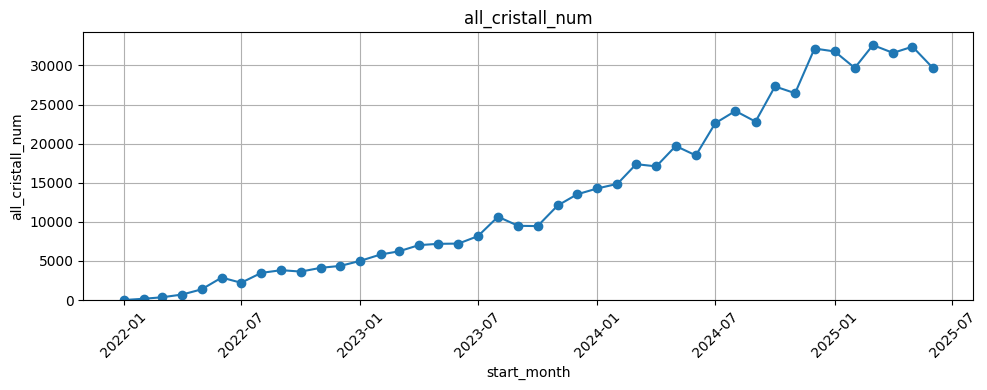

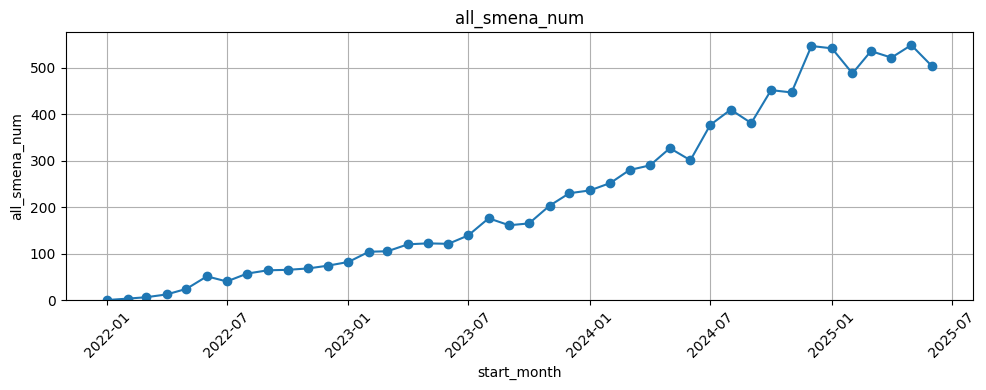

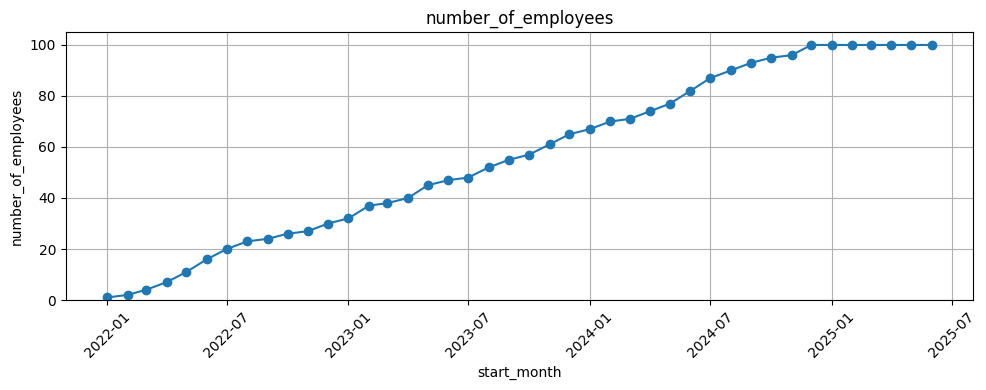

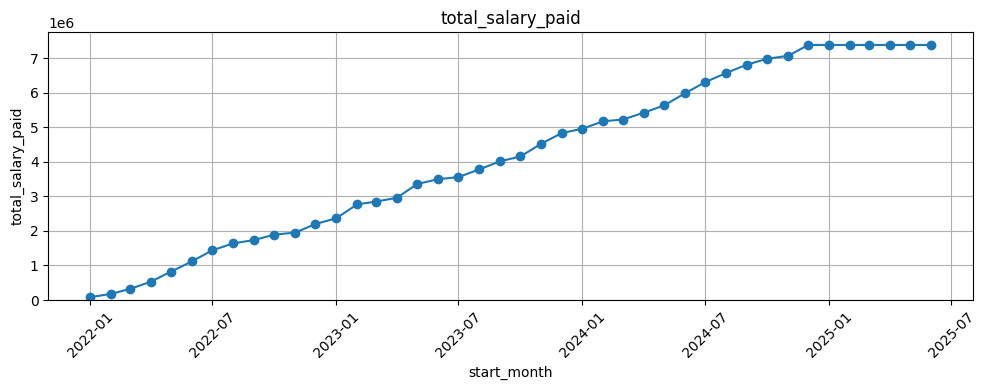

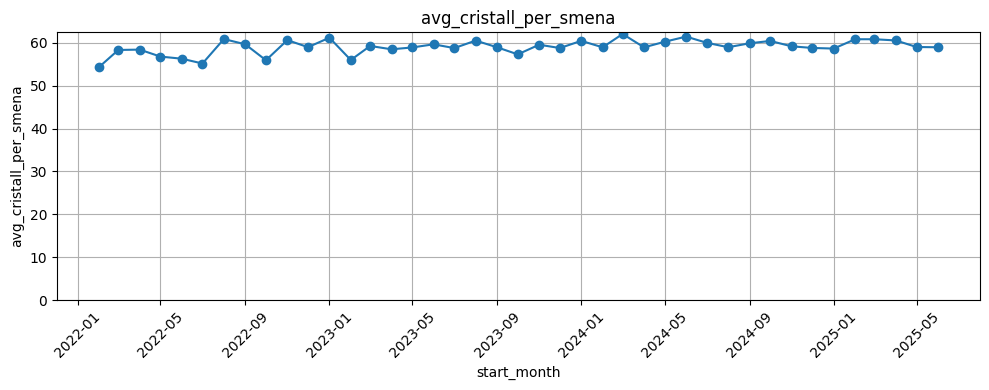

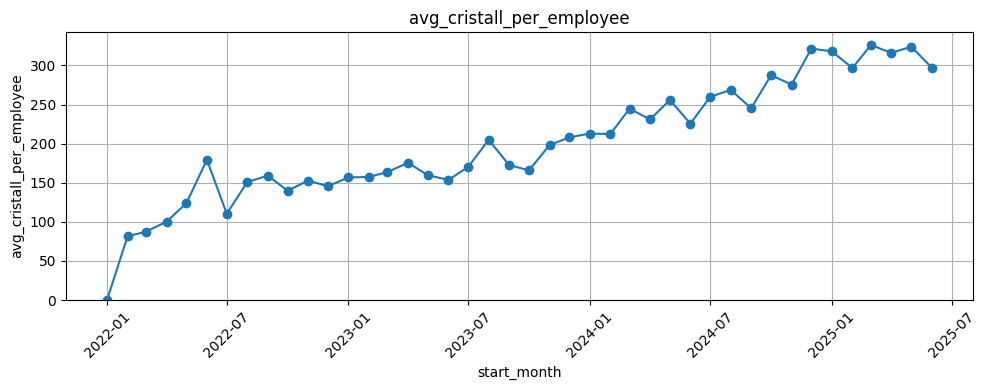

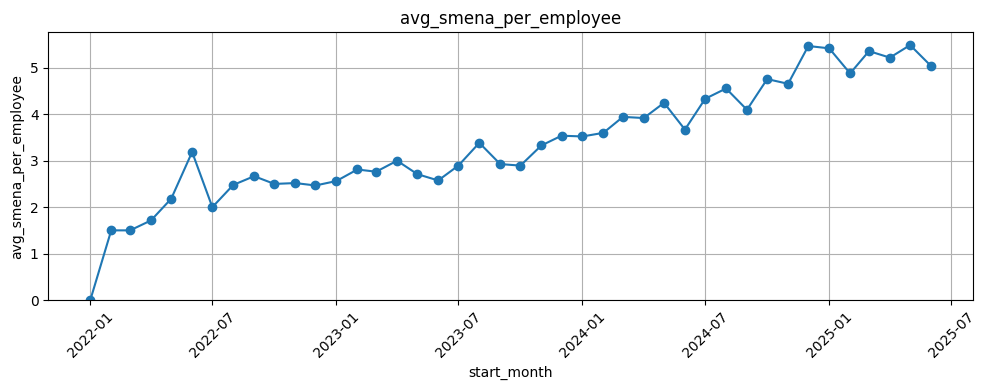

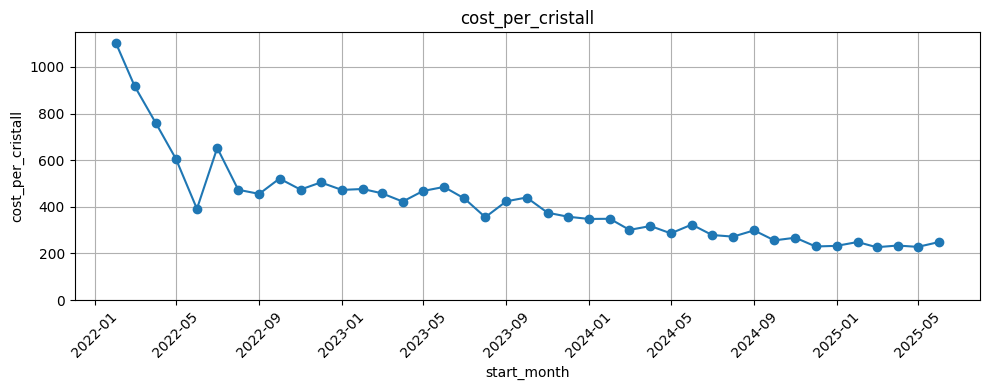

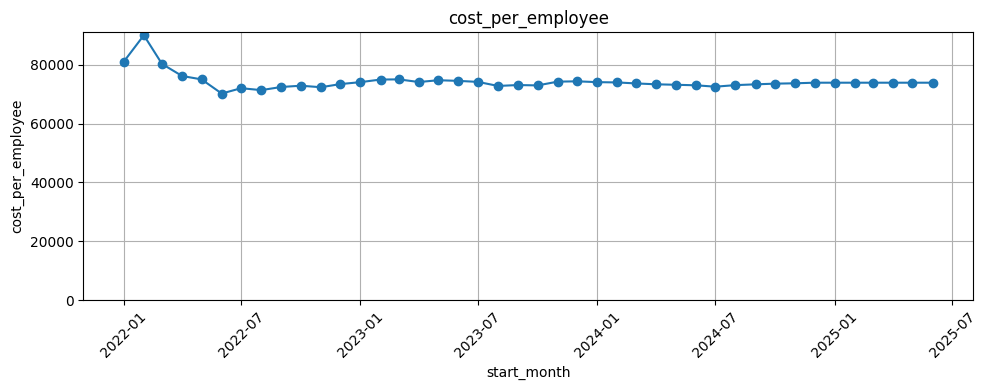

In [15]:
# Делаю визуализацию
df_total_by_month = df_total_by_month[df_total_by_month['start_month'] != today] # Для графика убираем последний месяц, так как он неполный и могут быть аномальные цифры

metrics = [
    'all_cristall_num',
    'all_smena_num',
    'number_of_employees',
    'total_salary_paid',
    'avg_cristall_per_smena',
    'avg_cristall_per_employee',
    'avg_smena_per_employee',
    'cost_per_cristall',
    'cost_per_employee'
]

df_total_by_month = df_total_by_month.sort_values('start_month') # Сортирую значения для отрисовки

for metric in metrics:
    plt.figure(figsize=(10, 4))
    plt.plot(df_total_by_month['start_month'], df_total_by_month[metric], marker='o')
    plt.title(metric)
    plt.xlabel('start_month')
    plt.ylabel(metric)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.ylim(bottom=0)
    plt.show()


#### Выводы по хорошо/плохо
Поскольку у нас синтетические данные с равномерным распределением распределением вероятности, то по большому счету уже данными задаются основные тренды.
Тем не менее, что видно:
1. Число сотрудников, смен и добытых кристаллов равномерно прирастает до декабря 2024, то есть основной прирост добычи происходит за счет увеличения числа сотрудников. Поскольку при генерации данных я ограничил найм до конца 2024, то в 2025 году рост практически остановился
2. Среднее число кристаллов на смену не растет, растет число смен
3. Но при этом данные сгенерировались таким образом, что средние затраты на добычу кристаллов падают с течением времени, при этом среднее число кристаллов на сотрудника растет. С учетом прошлых данных это говорит о том, что зп остается примерно такой же на сотрудника, эффективность за смену такая же, число сотрудников стабильное, но цена кристалла снижается. Это значит, что на одного сотрудника становится больше смен, то есть мы эффективнее платим зарплату, так как зп не привязана к числу смен и фиксирована. Но вообще даже этот вывод определяется самой логикой генерацией данных.

### Разделение сотрудников на когорты
Какие когорты можно посмотреть:
1. Самое базовое - когорта по дате найма. Можно разделить на несколько категорий, например, на равные квантили. Поскольку у нас равная вероятность трудоустройства в любую дату за 2022-2024 год, то просто поделю сотрудников на старичков (2022 год найма), средняков (2023 год найма), новички (2024 год найма). В принципе количество категорий может быть любым, но по годам проще всего в восприятии
2. Далее по этим когортам сравним средние значения, а также можно посмотреть распределение по когортам на дорогие/производительные, как по каждой когорте найма у нас меняется распределение по эффективности и зарплатам


In [16]:
# Анализ по когортам найма
df_total_by_employee_month['year_of_hire'] = df_total_by_employee_month['dt_start'].dt.year

df_year_cohort = df_total_by_employee_month.groupby('year_of_hire', as_index=False).agg(
    all_cristall_num=('total_num', 'sum'),
    all_smena_num=('smena_num', 'sum'),
    number_of_employees=('id', 'nunique'),
    total_salary_paid=('salary', 'sum')
)

df_year_cohort['avg_cristall_per_smena'] = df_year_cohort['all_cristall_num']/df_year_cohort['all_smena_num']
df_year_cohort['avg_cristall_per_employee'] = df_year_cohort['all_cristall_num']/df_year_cohort['number_of_employees']
df_year_cohort['avg_smena_per_employee'] = df_year_cohort['all_smena_num']/df_year_cohort['number_of_employees']
df_year_cohort['cost_per_cristall'] = df_year_cohort['total_salary_paid']/df_year_cohort['all_cristall_num']
df_year_cohort['cost_per_employee'] = df_year_cohort['total_salary_paid']/df_year_cohort['number_of_employees']

df_year_cohort

,year_of_hire,all_cristall_num,all_smena_num,number_of_employees,total_salary_paid,avg_cristall_per_smena,avg_cristall_per_employee,avg_smena_per_employee,cost_per_cristall,cost_per_employee
0,2022,181005.0,3066.0,30,82193000,59.036204,6033.500000,102.200000,454.092428,2.739767e+06
1,2023,206286.0,3464.0,35,66246000,59.551386,5893.885714,98.971429,321.136674,1.892743e+06
2,2024,208292.0,3470.0,35,33459000,60.026513,5951.200000,99.142857,160.635070,9.559714e+05


Видно, что по когорте новых нанятых людей за меньший срок было столько же смен, сколько по старым.
Причина - генерация данных. Сначала генерируется M смен, а потом им равновероятно присваивается сотрудник, который генерируется заранее. То есть вероятность того, что смена придется на нового сотрудника такая же, как если она придется на старого сотрудника. Поэтому число смен сопоставимо, но новый сотрудник "прожил" меньше месяцев, поэтому получил меньшую зп при той же добыче кристаллов. Это объясняет, почему у нас снижается себестоимость кристаллов и года в год.
И если бы это были фактические данные, можно было бы утверждать, что мы начали нанимать более "качественных сотрудников"

In [18]:
# Распределение сотрудников по эффективности по годам

df_cohort_employee = df_total_by_employee_month.groupby('id', as_index=False).agg(
    year_of_hire=('year_of_hire', 'max'),
    salary=('salary', 'max'),
    all_cristall_num=('total_num', 'sum'),
    all_smena_num=('smena_num', 'sum'),
    number_of_employees=('id', 'nunique'),
    total_salary_paid=('salary', 'sum')
)

df_cohort_employee['avg_cristall_per_smena'] = df_cohort_employee['all_cristall_num']/df_cohort_employee['all_smena_num']
df_cohort_employee['avg_cristall_per_employee'] = df_cohort_employee['all_cristall_num']/df_cohort_employee['number_of_employees']
df_cohort_employee['avg_smena_per_employee'] = df_cohort_employee['all_smena_num']/df_cohort_employee['number_of_employees']
df_cohort_employee['cost_per_cristall'] = df_cohort_employee['total_salary_paid']/df_cohort_employee['all_cristall_num']
df_cohort_employee['cost_per_employee'] = df_cohort_employee['total_salary_paid']/df_cohort_employee['number_of_employees']

# Сначала определяем категорию эффективности по среднему числу кристаллов - просто по процентилям на 3 категории
efficiency_list = [df_cohort_employee['avg_cristall_per_employee'].quantile(0.33),
                   df_cohort_employee['avg_cristall_per_employee'].quantile(0.66)]

# Далее оцениваем стоимость сотрудника по зарплате - просто по процентилям на 3 категории
cost_list = [df_cohort_employee['salary'].quantile(0.33),
             df_cohort_employee['salary'].quantile(0.66)]

def efficiency_category(row):
  if row['avg_cristall_per_employee'] <= efficiency_list[0]:
    res = 1 # Низкая производительность
  elif row['avg_cristall_per_employee'] > efficiency_list[1]:
    res = 3 # Высокая производительность
  else:
    res = 2 # Средняя производительность
  return res

def salary_category(row):
  if row['salary'] <= cost_list[0]:
    res = 1 # Низкая производительность
  elif row['salary'] > cost_list[1]:
    res = 3 # Высокая производительность
  else:
    res = 2 # Средняя производительность
  return res

df_cohort_employee['efficiency_category'] = df_cohort_employee.apply(efficiency_category, axis=1)
df_cohort_employee['salary_category'] = df_cohort_employee.apply(salary_category, axis=1)

df_cohort_employee

,id,year_of_hire,salary,all_cristall_num,all_smena_num,number_of_employees,total_salary_paid,avg_cristall_per_smena,avg_cristall_per_employee,avg_smena_per_employee,cost_per_cristall,cost_per_employee,efficiency_category,salary_category
0,1,2023,83000,5728.0,96.0,1,2490000,59.666667,5728.0,96.0,434.706704,2490000.0,2,3
1,2,2023,82000,6341.0,105.0,1,2214000,60.390476,6341.0,105.0,349.156284,2214000.0,3,2
2,3,2023,93000,5528.0,91.0,1,2883000,60.747253,5528.0,91.0,521.526773,2883000.0,1,3
3,4,2023,82000,5698.0,103.0,1,1886000,55.320388,5698.0,103.0,330.993331,1886000.0,1,2
4,5,2022,56000,6498.0,117.0,1,2016000,55.538462,6498.0,117.0,310.249307,2016000.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,2024,66000,6188.0,106.0,1,924000,58.377358,6188.0,106.0,149.321267,924000.0,3,1
96,97,2023,86000,5349.0,90.0,1,2236000,59.433333,5349.0,90.0,418.022060,2236000.0,1,3
97,98,2023,55000,6182.0,104.0,1,1100000,59.442308,6182.0,104.0,177.935943,1100000.0,2,1
98,99,2024,57000,6508.0,99.0,1,855000,65.737374,6508.0,99.0,131.376767,855000.0,3,1


In [19]:
# Теперь делаю сводные по годам и смотрю распределение по категориям по процентам
for y in (2022, 2023, 2024):
  df_for_pivot = df_cohort_employee[df_cohort_employee['year_of_hire'] == y]

  pivot = pd.pivot_table(
      df_for_pivot,
      index='efficiency_category',
      columns='salary_category',
      values='id',
      aggfunc='count',
      fill_value=0
  )

  pivot_percent = pivot / pivot.values.sum() * 100

  print(y)
  print(pivot_percent)
  print()

2022
salary_category              1          2     3
efficiency_category                            
1                    13.333333   6.666667  10.0
2                     6.666667   6.666667  10.0
3                    20.000000  16.666667  10.0

2023
salary_category              1          2          3
efficiency_category                                 
1                    20.000000   8.571429  11.428571
2                     8.571429   8.571429  17.142857
3                     2.857143  17.142857   5.714286

2024
salary_category              1          2          3
efficiency_category                                 
1                     8.571429  14.285714   5.714286
2                    17.142857   8.571429  14.285714
3                     8.571429  11.428571  11.428571



Опять же, из-за логики генерации данных распределение данных по каждой категории эффективности и костов примерно одинаковая, а отклонения в процентах объясняются низкой выборкой (в каждый год всего 30-35 записей).
Если бы это были реальные данные, я бы порекомендовал присмотреться к категории salary_category = 3, efficiency_category = 1, это сотрудники с высокой зп и низкой выработкой, возможно стоит провести работу с такими сотрудниками. Но видно, что в 2024 году доля таких сотрудников ниже, чем была в прошлые годы - это хороший знак